# Objective
- To classify gender of a person in an image using CNN

This is the second part of this series. In the first part, we looked at our data-set and downloaded the images from the Internet. In this part we will build a simple convolutional neural network in Keras to classify whether a person in an image is male or female.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
TRAIN_DIR = "./data/train"
TEST_DIR = "./data/test"
IM_WIDTH = 198
IM_HEIGHT = 198

In [3]:
def plot_images(images, labels):
    n_cols = min(5, len(images))
    n_rows = len(images) // n_cols
    fig = plt.figure(figsize=(10, 10))
 
    for i in range(n_rows * n_cols):
        sp = fig.add_subplot(n_rows, n_cols, i+1)
        plt.axis("off")
        plt.imshow(images[i], cmap=plt.cm.gray)
        sp.set_title(labels[i])
    plt.show()

In [ ]:
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, GlobalAvgPool2D
from keras.models import Model

img_input = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = Conv2D(filters=32, kernel_size=3)(img_input)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)

_ = Conv2D(filters=64, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)

_ = Conv2D(filters=64, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)

_ = Conv2D(filters=128, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = MaxPool2D()(_)

_ = Conv2D(filters=128, kernel_size=3)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)
_ = GlobalAvgPool2D()(_)

_ = Dense(128)(_)
_ = Activation("relu")(_)
_ = BatchNormalization()(_)

_ = Dense(1)(_)
_ = Activation("sigmoid")(_)

model = Model(inputs=img_input, outputs=_)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\Sanjaya\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We'll use ImageDataGenerator class provided by Keras library. It provides an easy way to generate batches of images with data augmentation. For our purpose, we'll define two data generators- one for training and one for testing.

For training data generator we'll tell it to perform the following:
- normalize the pixel values so that they lie between 0 and 1 instead of 0 and 255
- randomly rotate images from 0 to 20 degrees
- randomly flip the image horizontally

For testing data generator we'll only tell it to normalize the pixel values. You wouldn't randomly flip an input image when you model is deployed in production, would you?

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=20, 
                              horizontal_flip=True
                             )

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32
train_gen = train_data_gen.flow_from_directory(TRAIN_DIR,
                                               target_size=(IM_WIDTH, IM_HEIGHT), 
                                               class_mode="binary",
                                               batch_size=batch_size)
test_gen = test_data_gen.flow_from_directory(TEST_DIR,
                                            target_size=(IM_WIDTH, IM_HEIGHT),
                                            class_mode="binary",
                                            batch_size=batch_size)

In [10]:
history = model.fit_generator(train_gen, steps_per_epoch=len(train_gen.filenames)//batch_size, epochs=16)

Epoch 1/16
302/302 [==============================] - 132s - loss: 0.4542 - acc: 0.7822   
Epoch 2/16
302/302 [==============================] - 132s - loss: 0.4290 - acc: 0.7912   
Epoch 3/16
302/302 [==============================] - 132s - loss: 0.4080 - acc: 0.8043   
Epoch 4/16
302/302 [==============================] - 132s - loss: 0.3835 - acc: 0.8207   
Epoch 5/16
302/302 [==============================] - 132s - loss: 0.3527 - acc: 0.8375   
Epoch 6/16
302/302 [==============================] - 132s - loss: 0.3312 - acc: 0.8508   
Epoch 7/16
302/302 [==============================] - 137s - loss: 0.3112 - acc: 0.8557   
Epoch 8/16
302/302 [==============================] - 140s - loss: 0.2967 - acc: 0.8670   
Epoch 9/16
302/302 [==============================] - 136s - loss: 0.2784 - acc: 0.8765   
Epoch 10/16
302/302 [==============================] - 140s - loss: 0.2687 - acc: 0.8819   
Epoch 11/16
302/302 [==============================] - 135s - loss: 0.2517 - acc: 0.8881 

In [11]:
model.evaluate_generator(test_gen, steps=len(test_gen.filenames)//batch_size)

[0.25906037643205287, 0.8839631782945736]

In [ ]:
model.save("gender.model")
from keras.models import load_model
model = load_model("./gender.model")

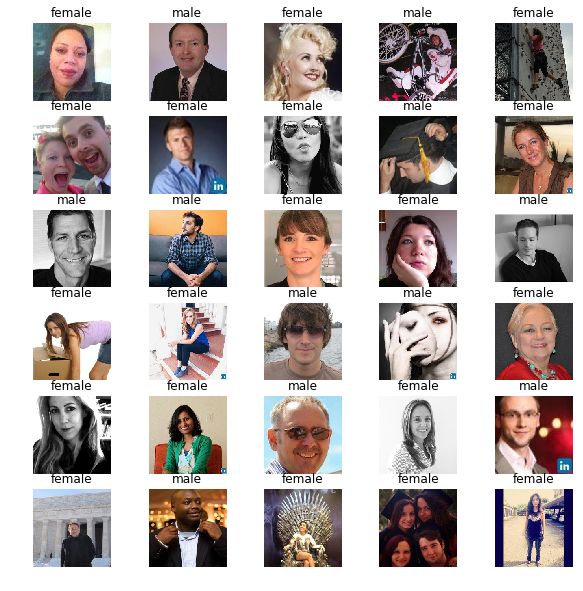

In [33]:
# predict for one batch of test images
imgs, y_true = next(test_gen)
predictions = model.predict(imgs, batch_size=imgs.shape[0])

# how do I know if male is 0 or 1? ImageDataGenerator has a property class_indices
# try printing test_gen.class_indices
# since sigmoid produces value between 0 and 1, we create a threshold and say
# any value > 0.5 is a male otherwise it is female
predictions_str = np.where(predictions.flatten() > 0.5, "male", "female")
plot_images(imgs, predictions_str)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true, (predictions.flatten() > 0.5).astype("int32")))

             precision    recall  f1-score   support

        0.0       0.90      0.95      0.93        20
        1.0       0.91      0.83      0.87        12

avg / total       0.91      0.91      0.91        32

